| Feature              | ACF (Autocorrelation Function)                   | STL (Seasonal-Trend decomposition using Loess)           |
| -------------------- | ------------------------------------------------ | -------------------------------------------------------- |
| **What it measures** | Correlation of the series with its own past lags | Decomposes the series into trend, seasonality, residuals |
| **Output**           | Correlation values for lags                      | Separate time series: trend, seasonal, residual          |
| **Use case**         | Identify autocorrelation and seasonality lags    | Visualize and quantify seasonal and trend components     |
| **Best for**         | Deciding model lags for ARIMA/SARIMA             | Understanding and visualizing seasonal structure         |
| **Visual tool**      | Bar plot of correlations (ACF/PACF plots)        | Time series line plots of components                     |
| **Interpretation**   | Peaks at lags = recurring cycles                 | Direct view of what the trend and seasonality look like  |


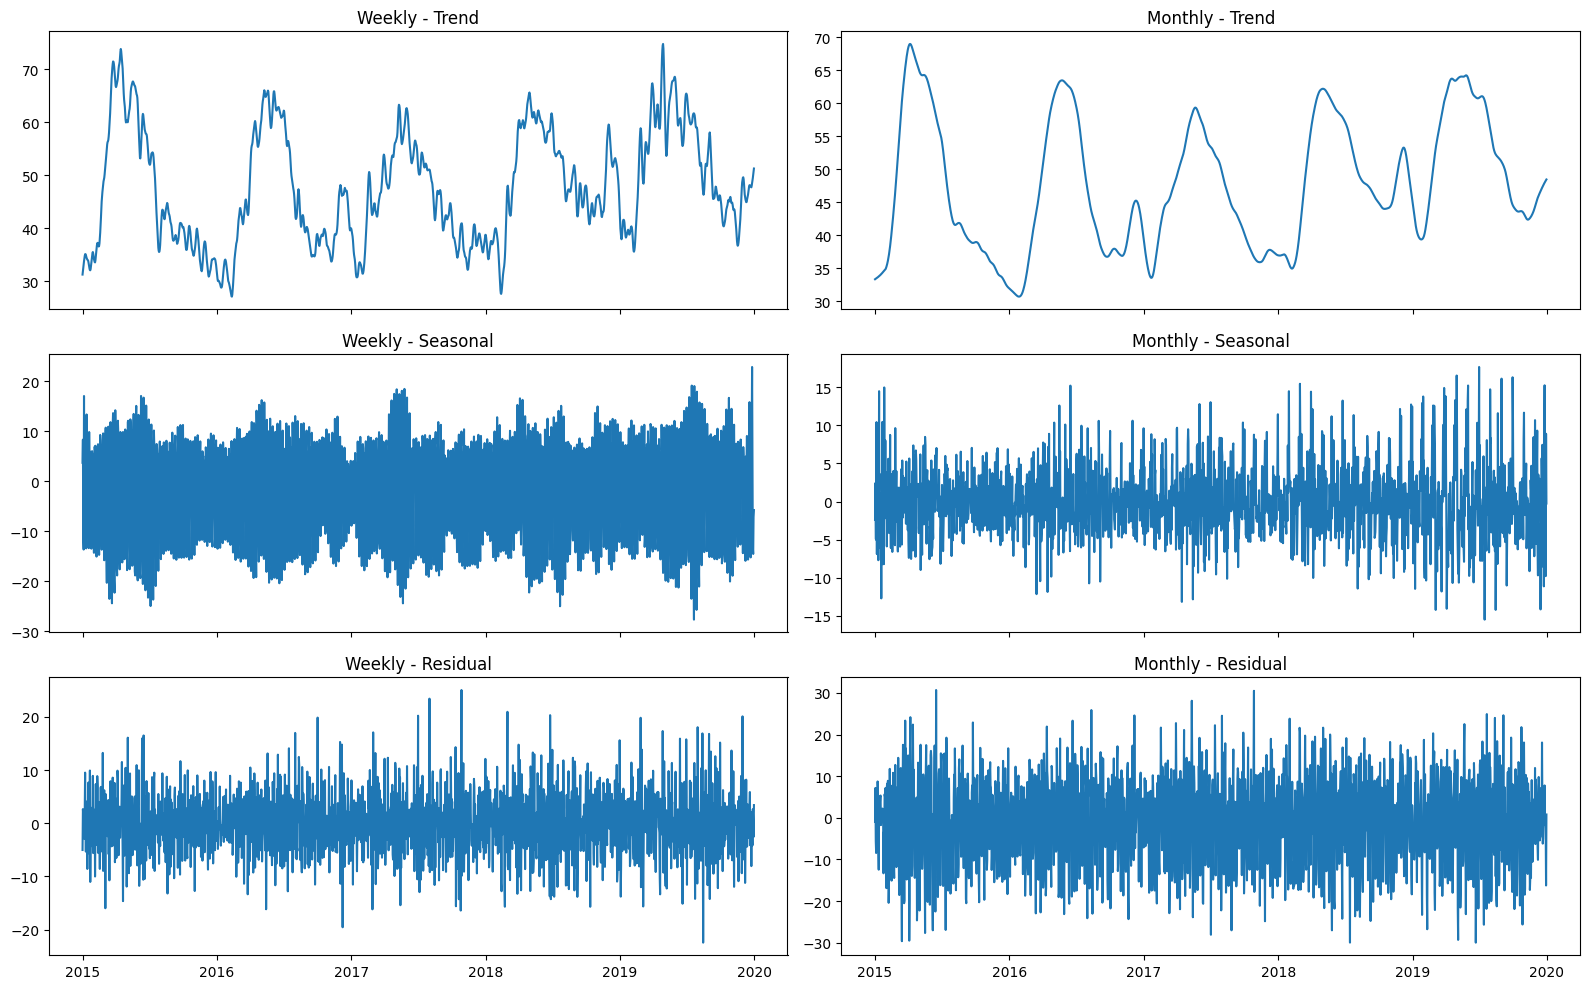

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf


# https://www.statsmodels.org/dev/examples/notebooks/generated/mstl_decomposition.html

# Step 1: Load and prepare the data
df = pd.read_csv("df_final_bh_amazonas.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

# Step 2: STL decomposition for weekly seasonality
stl_weekly = STL(df['NUMBER_INT'], period=7)
res_weekly = stl_weekly.fit()

# Step 3: STL decomposition for monthly seasonality (~30 days)
stl_monthly = STL(df['NUMBER_INT'], period=30)
res_monthly = stl_monthly.fit()

# Step 4: Plot both decompositions manually
fig, axs = plt.subplots(3, 2, figsize=(16, 10), sharex=True)

# Weekly
axs[0, 0].plot(res_weekly.trend)
axs[0, 0].set_title('Weekly - Trend')
axs[1, 0].plot(res_weekly.seasonal)
axs[1, 0].set_title('Weekly - Seasonal')
axs[2, 0].plot(res_weekly.resid)
axs[2, 0].set_title('Weekly - Residual')

# Monthly
axs[0, 1].plot(res_monthly.trend)
axs[0, 1].set_title('Monthly - Trend')
axs[1, 1].plot(res_monthly.seasonal)
axs[1, 1].set_title('Monthly - Seasonal')
axs[2, 1].plot(res_monthly.resid)
axs[2, 1].set_title('Monthly - Residual')

plt.tight_layout()
plt.show()


<Figure size 1800x600 with 0 Axes>

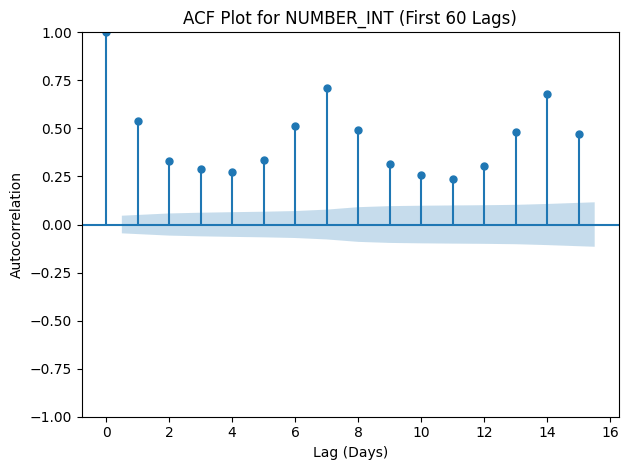

In [2]:
#Plot ACF  (see auto correlation)

y = df['NUMBER_INT']


plt.figure(figsize=(18, 6))
plot_acf(y, lags=15)
plt.title('ACF Plot for NUMBER_INT (First 60 Lags)')
plt.xlabel('Lag (Days)')
plt.ylabel('Autocorrelation')
plt.tight_layout()
plt.show()

<Figure size 1200x500 with 0 Axes>

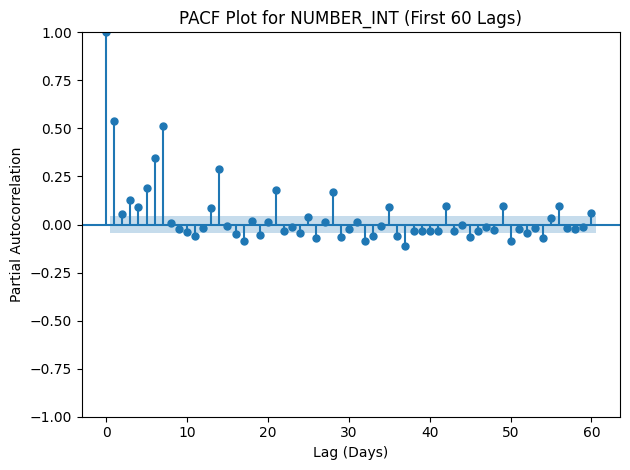

In [3]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(12, 5))
plot_pacf(df['NUMBER_INT'], lags=60, method='ywm')  # ywm = Yule-Walker Modified (safe default)
plt.title('PACF Plot for NUMBER_INT (First 60 Lags)')
plt.xlabel('Lag (Days)')
plt.ylabel('Partial Autocorrelation')
plt.tight_layout()
plt.show()

In [4]:
# Split
df = df.asfreq('D')

train = df.loc[:'2018-12-31']['NUMBER_INT']
val = df.loc['2019-01-01':]['NUMBER_INT']


In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Example SARIMA model from auto_arima suggestion
model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,0,7))
results = model.fit()

# Forecast for the length of the validation set
n_periods = len(val)
forecast = results.get_forecast(steps=n_periods)
forecast_df = forecast.conf_int()
forecast_df['Prediction'] = forecast.predicted_mean
forecast_df.index = val.index  # align index for comparison


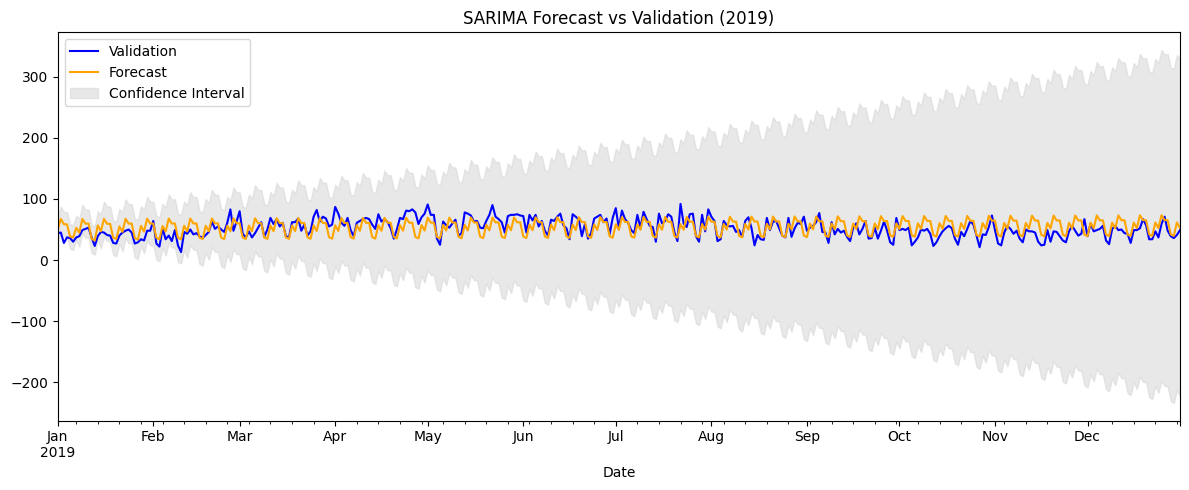

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Only validation and forecast
val.plot(label='Validation', color='blue')
forecast_df['Prediction'].plot(label='Forecast', color='orange')
plt.fill_between(
    forecast_df.index,
    forecast_df.iloc[:, 0],  # lower bound of CI
    forecast_df.iloc[:, 1],  # upper bound of CI
    color='lightgrey',
    alpha=0.5,
    label='Confidence Interval'
)

plt.title('SARIMA Forecast vs Validation (2019)')
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
# https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

# https://medium.com/data-science/time-series-forecasting-using-auto-arima-in-python-bb83e49210cd